In [1]:
import sys
import numpy as np

pi = np.pi
dtheta = pi/180.0
#lon,lat is degree

def lonlat2xyz(lon,lat):
    x = np.cos(lon*dtheta) * np.cos(lat*dtheta)
    y = np.sin(lon*dtheta) * np.cos(lat*dtheta)
    z = np.sin(lat*dtheta)
    return x,y,z

def xyz2lonlat(x,y,z):
    if(x != 0.0):
        lon = np.arctan2(y,x)
        if(lon < 0.0):
            lon += 2.0*pi
    else:
        lon = 0.0
    lon /= dtheta
    lat = np.arcsin(z)/dtheta
    return lon,lat

def uv2xyzd(u,v,lon,lat):
    xd = -u*np.sin(lon*dtheta) - v*np.cos(lon*dtheta)*np.sin(lat*dtheta)
    yd = u*np.cos(lon*dtheta) - v*np.sin(lon*dtheta)*np.sin(lat*dtheta)
    zd = v*np.cos(lat*dtheta)
    return xd,yd,zd

def xyzd2uv(xd,yd,zd,lon):
    u = -xd*np.sin(lon*dtheta) + yd*np.cos(lon*dtheta)
    v = np.sign(zd) * np.sqrt((xd*np.cos(lon*dtheta) + yd*np.sin(lon*dtheta))**2 + zd**2)
    return u,v

def generate_points(nlon,nlat,dlat):
    dlon = 360.0/nlon
    lon = dlon * np.arange(nlon)
    lat = 90.0 - dlat * np.arange(nlat)
    return lon,lat

#Ax
def np2tc(lonc,latc,x,y,z):
    xx = np.cos(lonc*dtheta)*np.sin(latc*dtheta)*x\
        - np.sin(lonc*dtheta)*y\
        + np.cos(lonc*dtheta)*np.cos(latc*dtheta)*z
    yy = np.sin(lonc*dtheta)*np.sin(latc*dtheta)*x\
        + np.cos(lonc*dtheta)*y\
        + np.sin(lonc*dtheta)*np.cos(latc*dtheta)*z
    zz = -np.cos(latc*dtheta)*x + np.sin(latc*dtheta)*z
    return xx,yy,zz
#ATx
def tc2np(lonc,latc,x,y,z):
    xx = np.cos(lonc*dtheta)*np.sin(latc*dtheta)*x\
        + np.sin(lonc*dtheta)*np.sin(latc*dtheta)*y\
        - np.cos(latc*dtheta)*z
    yy = -np.sin(lonc*dtheta)*x + np.cos(lonc*dtheta)*y
    zz = np.cos(lonc*dtheta)*np.cos(latc*dtheta)*x\
        + np.sin(lonc*dtheta)*np.cos(latc*dtheta)*y\
        + np.sin(latc*dtheta)*z
    return xx,yy,zz

def rotate_lonlat(lonc,latc,lon,lat):
    nlon = lon.size
    nlat = lat.size
    lonout = np.zeros(nlon*nlat)
    latout = np.zeros(nlon*nlat)
    ij = 0
    for j in range(nlat):
        for i in range(nlon):
            x,y,z = lonlat2xyz(lon[i],lat[j])
            xx,yy,zz = np2tc(lonc,latc,x,y,z)
            lonout[ij],latout[ij] = xyz2lonlat(xx,yy,zz)
            ij += 1
    return lonout,latout

def sgn(x):
    return (x>0).astype(np.int)-(x<0).astype(np.int)

In [96]:
x = np.linspace(0,2*np.pi,20)
z = np.sin(x)
print(z)
print((z>0).astype(np.int))
sgn(z)

[ 0.00000000e+00  3.24699469e-01  6.14212713e-01  8.37166478e-01
  9.69400266e-01  9.96584493e-01  9.15773327e-01  7.35723911e-01
  4.75947393e-01  1.64594590e-01 -1.64594590e-01 -4.75947393e-01
 -7.35723911e-01 -9.15773327e-01 -9.96584493e-01 -9.69400266e-01
 -8.37166478e-01 -6.14212713e-01 -3.24699469e-01 -2.44929360e-16]
[0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]


array([ 0,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1])

In [2]:
from pathlib import Path
from datetime import datetime, timedelta
import xarray as xr
import pandas as pd
#import librotate

#Usage echo yyyymmddhh nlon nlat latmax | python rotate_scalar.py
#param = sys.stdin.readline().strip("\n").split(" ")
param = ["2019100900","100","50","8"]
yyyymmddhh = param[0]
nlon       = int(param[1])
nlat       = int(param[2])
latmax     = float(param[3]) #degree
dlat = latmax/nlat #degree

datadir = Path('./')
outdir = Path('./')
innc = yyyymmddhh+'_mean.nc'
outnc = 'np_sc_'+innc
trackf = Path('./track'+yyyymmddhh+'.txt')

var_sfc = ['PRES_meansealevel',\
           'TMP_2maboveground','DPT_2maboveground']
var_pl = ['TMP_000mb','SPFH_000mb','HGT_000mb']

lonin,latin = generate_points(nlon,nlat,dlat)
print(lonin)
print(latin)

[  0.    3.6   7.2  10.8  14.4  18.   21.6  25.2  28.8  32.4  36.   39.6
  43.2  46.8  50.4  54.   57.6  61.2  64.8  68.4  72.   75.6  79.2  82.8
  86.4  90.   93.6  97.2 100.8 104.4 108.  111.6 115.2 118.8 122.4 126.
 129.6 133.2 136.8 140.4 144.  147.6 151.2 154.8 158.4 162.  165.6 169.2
 172.8 176.4 180.  183.6 187.2 190.8 194.4 198.  201.6 205.2 208.8 212.4
 216.  219.6 223.2 226.8 230.4 234.  237.6 241.2 244.8 248.4 252.  255.6
 259.2 262.8 266.4 270.  273.6 277.2 280.8 284.4 288.  291.6 295.2 298.8
 302.4 306.  309.6 313.2 316.8 320.4 324.  327.6 331.2 334.8 338.4 342.
 345.6 349.2 352.8 356.4]
[90.   89.84 89.68 89.52 89.36 89.2  89.04 88.88 88.72 88.56 88.4  88.24
 88.08 87.92 87.76 87.6  87.44 87.28 87.12 86.96 86.8  86.64 86.48 86.32
 86.16 86.   85.84 85.68 85.52 85.36 85.2  85.04 84.88 84.72 84.56 84.4
 84.24 84.08 83.92 83.76 83.6  83.44 83.28 83.12 82.96 82.8  82.64 82.48
 82.32 82.16]


In [3]:
da_np=[]
with trackf.open() as track:
    #l = track.readline()
    for l in track:
        l_split = l.split()
        print(l_split)
        year  = l_split[0]
        month = l_split[1]
        day   = l_split[2]
        hour  = l_split[3]
        date_str  = year+'/'+month+'/'+day+' '+hour+':00'
        print(date_str)
        date = datetime.strptime(date_str,'%Y/%m/%d %H:%M')
        print(date)
        lonc  = float(l_split[4])
        latc  = float(l_split[5])
        print(lonc,latc)
    
        lonout,latout = rotate_lonlat(lonc,latc,lonin,latin) #need to be plotted
        print(lonout.reshape(nlat,nlon))
        print(latout.reshape(nlat,nlon))

        print(datadir/innc)
        with xr.open_dataset(datadir / innc).sel(time=date) as data:
            print(data)

            lon = data["longitude"].values
            lat = data["latitude"].values
            print(lon,lat)
            attrs_time = data["time"].attrs
            attrs_lon = data["longitude"].attrs
            attrs_lat = data["latitude"].attrs
            print(attrs_time,attrs_lon,attrs_lat)
            newlon = xr.DataArray(lonout,dims='np_lonlat')
            newlat = xr.DataArray(latout,dims='np_lonlat')
            nplon = xr.DataArray(lonin,coords={'time':data["time"], 'longitude':lonin},
                     dims='longitude',attrs=attrs_lon, name='longitude')
            nplat = xr.DataArray(latin,coords={'time':data["time"], 'latitude':latin},
                     dims='latitude',attrs=attrs_lat, name='latitude')
            print(nplon,nplat)
            vname = var_sfc[0]
            daout=[]
            for vname in var_sfc:
                datain = data[vname] 
                #missing values need to be searched
                df = datain.to_pandas()
                if(df.isnull().values.sum() != 0):
                    print("missing value exists in input data.")
                    continue
                inattrs = datain.attrs
                print(inattrs)
                data_interp = datain.interp(longitude=newlon, latitude=newlat)
                df = data_interp.to_pandas()
                if(df.isnull().values.sum() != 0):
                    print("missing value exists in interpolation data.")
                    continue
                print(data_interp)
                value = data_interp.values
                print(value)
                dataout = xr.DataArray(value.reshape(1,nlat,nlon),\
                           [('time',pd.date_range(date,periods=1)),\
                         ('latitude',nplat),('longitude',nplon)],\
                           attrs=inattrs,name=vname)
                print(dataout)
                daout.append(dataout)
        
            for vname in var_pl:
                for lev in ['200','250','300','500','850']:
                    vname_pl = vname.replace('000',lev)
                    datain = data[vname_pl]
                    #missing values need to be searched
                    df = datain.to_pandas()
                    if(df.isnull().values.sum() != 0):
                        print("missing value exists in input data.")
                        continue
                    inattrs = datain.attrs
                    print(inattrs)
                    data_interp = \
                    datain.interp(longitude=newlon, latitude=newlat)
                    #missing values need to be searched
                    df = data_interp.to_pandas()
                    if(df.isnull().values.sum() != 0):
                        print("missing value exists in interpolation data.")
                        continue
                    value = data_interp.values
                    dataout = xr.DataArray(value.reshape(1,nlat,nlon),\
                               [('time',pd.date_range(date,periods=1)),\
                                ('latitude',nplat),('longitude',nplon)],\
                               attrs=inattrs,name=vname_pl)
                    print(dataout)
                    daout.append(dataout)

            da_np.append(xr.merge(daout))
            print(da_np[0]["longitude"])
data_np = xr.merge(da_np)
print(data_np)

data_np.to_netcdf(outdir / outnc, 'w')
#da_np[0].to_netcdf(outdir / outnc, 'w')

['2019', '10', '9', '0', '140.0347168059274', '19.98207077834067', '95650.44815609399']
2019/10/9 0:00
2019-10-09 00:00:00
140.0347168059274 19.98207077834067
[[140.03471681 140.03471681 140.03471681 ... 140.03471681 140.03471681
  140.03471681]
 [140.03471681 140.04539604 140.05603325 ... 140.00284702 140.01340036
  140.02403757]
 [140.03471681 140.05605383 140.07730716 ... 139.97104021 139.99212645
  140.01337978]
 ...
 [140.03471681 140.51694008 140.9974531  ... 138.59488283 139.07198051
  139.55249353]
 [140.03471681 140.52683792 141.01721625 ... 138.56531927 139.05221736
  139.54259569]
 [140.03471681 140.53672371 141.0369554  ... 138.5357915  139.03247821
  139.5327099 ]]
[[19.98207078 19.98207078 19.98207078 ... 19.98207078 19.98207078
  19.98207078]
 [19.82207078 19.82238618 19.82333115 ... 19.82490198 19.82333115
  19.82238618]
 [19.66207078 19.66270095 19.66458901 ... 19.66772753 19.66458901
  19.66270095]
 ...
 [12.46207078 12.47631239 12.51898571 ... 12.5899364  12.51898571

[[139.98672444 139.98672444 139.98672444 ... 139.98672444 139.98672444
  139.98672444]
 [139.98672444 139.99746891 140.00817112 ... 139.95465994 139.96527777
  139.97597997]
 [139.98672444 140.0081907  140.02957277 ... 139.92266209 139.94387612
  139.96525819]
 ...
 [139.98672444 140.47077712 140.95312538 ... 138.54137906 139.02032351
  139.50267177]
 [139.98672444 140.48068864 140.97291636 ... 138.51177264 139.00053253
  139.49276025]
 [139.98672444 140.49058715 140.99268141 ... 138.48220486 138.98076748
  139.48286174]]
[[20.9256724  20.9256724  20.9256724  ... 20.9256724  20.9256724
  20.9256724 ]
 [20.7656724  20.76598778 20.76693271 ... 20.76850345 20.76693271
  20.76598778]
 [20.6056724  20.60630251 20.60819036 ... 20.61132856 20.60819036
  20.60630251]
 ...
 [13.4056724  13.41988046 13.46245363 ... 13.53323896 13.46245363
  13.41988046]
 [13.2456724  13.26017138 13.30361628 ... 13.37585118 13.30361628
  13.26017138]
 [13.0856724  13.10046191 13.14477741 ... 13.21845996 13.144777

[[139.93183631 139.93183631 139.93183631 ... 139.93183631 139.93183631
  139.93183631]
 [139.93183631 139.94261691 139.9533551  ... 139.89966399 139.91031753
  139.92105572]
 [139.93183631 139.95337414 139.97482752 ... 139.8675603  139.8888451
  139.91029848]
 ...
 [139.93183631 140.41691869 140.9002996  ... 138.48339011 138.96337302
  139.44675394]
 [139.93183631 140.42683853 140.92010747 ... 138.45375776 138.94356516
  139.43683409]
 [139.93183631 140.43674484 140.93988837 ... 138.4241656  138.92378425
  139.42692778]]
[[21.42625745 21.42625745 21.42625745 ... 21.42625745 21.42625745
  21.42625745]
 [21.26625745 21.26657283 21.26751773 ... 21.26908842 21.26751773
  21.26657283]
 [21.10625745 21.10688753 21.10877528 ... 21.1119133  21.10877528
  21.10688753]
 ...
 [13.90625745 13.92044762 13.96296733 ... 14.03366441 13.96296733
  13.92044762]
 [13.74625745 13.76073779 13.80412703 ... 13.87627003 13.80412703
  13.76073779]
 [13.58625745 13.60102757 13.64528516 ... 13.71887208 13.645285

[[139.02908675 139.02908675 139.02908675 ... 139.02908675 139.02908675
  139.02908675]
 [139.02908675 139.03994658 139.0507637  ... 138.99667794 139.0074098
  139.01822692]
 [139.02908675 139.05078159 139.0723914  ... 138.96434204 138.9857821
  139.00739191]
 ...
 [139.02908675 139.51646323 140.00214413 ... 137.57373492 138.05602937
  138.54171027]
 [139.02908675 139.52640293 140.02199221 ... 137.54404103 138.03618129
  138.53177057]
 [139.02908675 139.53632799 140.04181112 ... 137.51439059 138.01636239
  138.52184551]]
[[22.47567615 22.47567615 22.47567615 ... 22.47567615 22.47567615
  22.47567615]
 [22.31567615 22.31599151 22.31693635 ... 22.31850695 22.31693635
  22.31599151]
 [22.15567615 22.15630615 22.15819368 ... 22.16133133 22.15819368
  22.15630615]
 ...
 [14.95567615 14.96982853 15.01223541 ... 15.08274621 15.01223541
  14.96982853]
 [14.79567615 14.81011714 14.8533889  ... 14.92533792 14.8533889
  14.81011714]
 [14.63567615 14.65040533 14.69454069 ... 14.76792581 14.69454069

[[138.89426753 138.89426753 138.89426753 ... 138.89426753 138.89426753
  138.89426753]
 [138.89426753 138.9052032  138.91609586 ... 138.86163238 138.87243921
  138.88333187]
 [138.89426753 138.91611269 138.93787224 ... 138.82907413 138.85066282
  138.87242238]
 ...
 [138.89426753 139.38387917 139.87180017 ... 137.43219064 137.9167349
  138.4046559 ]
 [138.89426753 139.39383965 139.89169024 ... 137.40243265 137.89684482
  138.39469542]
 [138.89426753 139.40378447 139.91154913 ... 137.37272112 137.87698594
  138.3847506 ]]
[[23.4245771  23.4245771  23.4245771  ... 23.4245771  23.4245771
  23.4245771 ]
 [23.2645771  23.26489244 23.26583723 ... 23.26740775 23.26583723
  23.26489244]
 [23.1045771  23.10520703 23.10709436 ... 23.11023168 23.10709436
  23.10520703]
 ...
 [15.9045771  15.91869499 15.9609989  ... 16.03133967 15.9609989
  15.91869499]
 [15.7445771  15.75898219 15.80214673 ... 15.87391872 15.80214673
  15.75898219]
 [15.5845771  15.59926894 15.64329276 ... 15.71649371 15.64329276

[[138.48767862 138.48767862 138.48767862 ... 138.48767862 138.48767862
  138.48767862]
 [138.48767862 138.49866399 138.50960617 ... 138.45489512 138.46575107
  138.47669325]
 [138.48767862 138.50962231 138.53148004 ... 138.42219108 138.44387721
  138.46573493]
 ...
 [138.48767862 138.97877324 139.46818016 ... 137.02114116 137.50717709
  137.996584  ]
 [138.48767862 138.98874815 139.48809937 ... 136.99133878 137.48725788
  137.98660909]
 [138.48767862 138.99870675 139.5079861  ... 136.96158478 137.46737115
  137.97665049]]
[[24.02037198 24.02037198 24.02037198 ... 24.02037198 24.02037198
  24.02037198]
 [23.86037198 23.86068732 23.86163207 ... 23.86320254 23.86163207
  23.86068732]
 [23.70037198 23.70100187 23.70288907 ... 23.70602617 23.70288907
  23.70100187]
 ...
 [16.50037198 16.51446806 16.55670681 ... 16.62693999 16.55670681
  16.51446806]
 [16.34037198 16.35475436 16.39785107 ... 16.46951105 16.39785107
  16.35475436]
 [16.18037198 16.19504019 16.23899346 ... 16.3120779  16.23899

[[137.55703891 137.55703891 137.55703891 ... 137.55703891 137.55703891
  137.55703891]
 [137.55703891 137.56810949 137.57913654 ... 137.52400109 137.53494127
  137.54596833]
 [137.55703891 137.57915154 137.60117757 ... 137.49104708 137.51290025
  137.53492628]
 ...
 [137.55703891 138.05070411 138.54268614 ... 136.08277178 136.57139168
  137.06337371]
 [137.55703891 138.06070504 138.56265784 ... 136.05288954 136.55141998
  137.05337278]
 [137.55703891 138.07068858 138.58259492 ... 136.02305887 136.5314829
  137.04338923]]
[[24.99854112 24.99854112 24.99854112 ... 24.99854112 24.99854112
  24.99854112]
 [24.83854112 24.83885643 24.83980114 ... 24.84137151 24.83980114
  24.83885643]
 [24.67854112 24.67917093 24.68105791 ... 24.68419466 24.68105791
  24.67917093]
 ...
 [17.47854112 17.49260108 17.53473198 ... 17.60478705 17.53473198
  17.49260108]
 [17.31854112 17.3328859  17.37587034 ... 17.4473449  17.37587034
  17.3328859 ]
 [17.15854112 17.17317022 17.21700672 ... 17.2898983  17.217006

[[137.48172923 137.48172923 137.48172923 ... 137.48172923 137.48172923
  137.48172923]
 [137.48172923 137.4928968  137.50402048 ... 137.44840191 137.45943797
  137.47056165]
 [137.48172923 137.5040342  137.52625186 ... 137.41516324 137.4372066
  137.45942425]
 ...
 [137.48172923 137.97835805 138.47330819 ... 135.99855346 136.49015026
  136.9851004 ]
 [137.48172923 137.98839031 138.49334303 ... 135.96857532 136.47011542
  136.97506815]
 [137.48172923 137.99840399 138.51334088 ... 135.93865226 136.45011758
  136.96505447]]
[[26.05273677 26.05273677 26.05273677 ... 26.05273677 26.05273677
  26.05273677]
 [25.89273677 25.89305206 25.8939967  ... 25.89556698 25.8939967
  25.89305206]
 [25.73273677 25.7333665  25.73525324 ... 25.7383896  25.73525324
  25.7333665 ]
 ...
 [18.53273677 18.54675736 18.58877071 ... 18.65863165 18.58877071
  18.54675736]
 [18.37273677 18.38704057 18.42990265 ... 18.50117515 18.42990265
  18.38704057]
 [18.21273677 18.22732326 18.2710325  ... 18.34371393 18.2710325

[[137.39722636 137.39722636 137.39722636 ... 137.39722636 137.39722636
  137.39722636]
 [137.39722636 137.4085305  137.41979021 ... 137.36349146 137.3746625
  137.38592222]
 [137.39722636 137.41980218 137.44228967 ... 137.32985189 137.35216305
  137.37465054]
 ...
 [137.39722636 137.8980827  138.39726569 ... 135.90134698 136.39718703
  136.89637002]
 [137.39722636 137.90816158 138.41739442 ... 135.87122642 136.3770583
  136.88629113]
 [137.39722636 137.91822028 138.43748296 ... 135.84116571 136.35696976
  136.87623243]]
[[27.4439947  27.4439947  27.4439947  ... 27.4439947  27.4439947
  27.4439947 ]
 [27.2839947  27.28430996 27.28525453 ... 27.28682467 27.28525453
  27.28430996]
 [27.1239947  27.12462432 27.12651075 ... 27.12964658 27.12651075
  27.12462432]
 ...
 [19.9239947  19.93796259 19.97981854 ... 20.04941951 19.97981854
  19.93796259]
 [19.7639947  19.77824365 19.82094193 ... 19.89194386 19.82094193
  19.77824365]
 [19.6039947  19.61852416 19.66206306 ... 19.73446315 19.66206306

[[136.5007701  136.5007701  136.5007701  ... 136.5007701  136.5007701
  136.5007701 ]
 [136.5007701  136.5121784  136.52354188 ... 136.46672431 136.47799832
  136.4893618 ]
 [136.5007701  136.52355254 136.54624587 ... 136.43277888 136.45529433
  136.47798766]
 ...
 [136.5007701  137.00488616 137.50733229 ... 134.99509807 135.49420792
  135.99665404]
 [136.5007701  137.01500225 137.52753588 ... 134.9648641  135.47400433
  135.98653796]
 [136.5007701  137.02509696 137.5476969  ... 134.93469351 135.4538433
  135.97644324]]
[[28.44146637 28.44146637 28.44146637 ... 28.44146637 28.44146637
  28.44146637]
 [28.28146637 28.28178161 28.28272612 ... 28.28429617 28.28272612
  28.28178161]
 [28.12146637 28.12209592 28.12398211 ... 28.12711756 28.12398211
  28.12209592]
 ...
 [20.92146637 20.9353959  20.97713729 ... 21.04654904 20.97713729
  20.9353959 ]
 [20.76146637 20.77567541 20.81825447 ... 20.88905949 20.81825447
  20.77567541]
 [20.60146637 20.61595433 20.65936929 ... 20.73156463 20.6593692

  * longitude  (longitude) float64 0.0 3.6 7.2 10.8 ... 345.6 349.2 352.8 356.4
['2019', '10', '11', '12', '136.4314710621969', '29.89398401448318', '95868.3711980142']
2019/10/11 12:00
2019-10-11 12:00:00
136.4314710621969 29.89398401448318
[[136.43147106 136.43147106 136.43147106 ... 136.43147106 136.43147106
  136.43147106]
 [136.43147106 136.44304087 136.45456524 ... 136.39694322 136.40837688
  136.41990125]
 [136.43147106 136.45457391 136.47758644 ... 136.36252342 136.38535568
  136.40836822]
 ...
 [136.43147106 136.94068886 137.44824113 ... 134.91047646 135.41470099
  135.92225326]
 [136.43147106 136.95086487 137.46856522 ... 134.88006012 135.3943769
  135.91207726]
 [136.43147106 136.96101772 137.48884319 ... 134.84971243 135.37409893
  135.90192441]]
[[29.89398401 29.89398401 29.89398401 ... 29.89398401 29.89398401
  29.89398401]
 [29.73398401 29.73429923 29.73524365 ... 29.73681356 29.73524365
  29.73429923]
 [29.57398401 29.57461345 29.57649929 ... 29.57963417 29.57649929
  2

<xarray.DataArray 'TMP_500mb' (time: 1, latitude: 50, longitude: 100)>
array([[[275.18203666, 275.18203666, 275.18203666, ..., 275.18203666,
         275.18203666, 275.18203666],
        [275.25186849, 275.25138327, 275.25064818, ..., 275.25157794,
         275.25198926, 275.25207856],
        [275.32170032, 275.31677607, 275.31141488, ..., 275.33273914,
         275.32979018, 275.32607513],
        ...,
        [271.54378028, 271.55658559, 271.57790632, ..., 271.47192298,
         271.49010055, 271.51922872],
        [271.46590868, 271.47856033, 271.50057098, ..., 271.38831486,
         271.40699264, 271.43884655],
        [271.38803709, 271.40051088, 271.4232658 , ..., 271.3047357 ,
         271.32393455, 271.35835747]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-10-11T12:00:00
  * latitude   (latitude) float64 90.0 89.84 89.68 89.52 ... 82.48 82.32 82.16
  * longitude  (longitude) float64 0.0 3.6 7.2 10.8 ... 345.6 349.2 352.8 356.4
Attributes:
    long_name:   Temperat

[[136.50686544 136.50686544 136.50686544 ... 136.50686544 136.50686544
  136.50686544]
 [136.50686544 136.51851313 136.53011507 ... 136.47210518 136.48361581
  136.49521775]
 [136.50686544 136.53012279 136.55328924 ... 136.43745663 136.46044164
  136.48360809]
 ...
 [136.50686544 137.01855997 137.52859077 ... 134.9784336  135.48514011
  135.99517091]
 [136.50686544 137.02876568 137.54897455 ... 134.94792696 135.46475632
  135.9849652 ]
 [136.50686544 137.03894739 137.56931056 ... 134.91749145 135.44442032
  135.97478349]]
[[30.55791826 30.55791826 30.55791826 ... 30.55791826 30.55791826
  30.55791826]
 [30.39791826 30.39823347 30.39917784 ... 30.40074769 30.39917784
  30.39823347]
 [30.23791826 30.23854764 30.24043332 ... 30.24356793 30.24043332
  30.23854764]
 ...
 [23.03791826 23.05176466 23.09325776 ... 23.16225931 23.09325776
  23.05176466]
 [22.87791826 22.89204081 22.93436154 ... 23.00473977 22.93436154
  22.89204081]
 [22.71791826 22.73231631 22.77546272 ... 22.8472144  22.77546

[[137.45555121 137.45555121 137.45555121 ... 137.45555121 137.45555121
  137.45555121]
 [137.45555121 137.46743267 137.47926749 ... 137.42009322 137.43183493
  137.44366975]
 [137.45555121 137.47927239 137.50290094 ... 137.38475786 137.40820149
  137.43183003]
 ...
 [137.45555121 137.97473135 138.4922521  ... 135.90464553 136.41885032
  136.93637107]
 [137.45555121 137.98502871 138.51282003 ... 135.87386056 136.39828239
  136.92607372]
 [137.45555121 137.99529961 138.5333353  ... 135.84315398 136.37776712
  136.91580281]]
[[32.42786643 32.42786643 32.42786643 ... 32.42786643 32.42786643
  32.42786643]
 [32.26786643 32.2681816  32.26912586 ... 32.27069551 32.26912586
  32.2681816 ]
 [32.10786643 32.10849566 32.11038087 ... 32.11351471 32.11038087
  32.10849566]
 ...
 [24.90786643 24.92163719 24.96290431 ... 25.03153252 24.96290431
  24.92163719]
 [24.74786643 24.7619103  24.80399598 ... 24.87398584 24.80399598
  24.7619103 ]
 [24.58786643 24.60218271 24.64508483 ... 24.71643286 24.64508

  * longitude  (longitude) float64 0.0 3.6 7.2 10.8 ... 345.6 349.2 352.8 356.4
['2019', '10', '12', '6', '138.4093026992641', '33.894866491116254', '96662.16744653457']
2019/10/12 6:00
2019-10-12 06:00:00
138.4093026992641 33.894866491116254
[[138.4093027  138.4093027  138.4093027  ... 138.4093027  138.4093027
  138.4093027 ]
 [138.4093027  138.4213834  138.43341669 ... 138.37325006 138.38518871
  138.397222  ]
 [138.4093027  138.43341921 138.45744161 ... 138.33732929 138.36116379
  138.38518619]
 ...
 [138.4093027  138.93490731 139.45885524 ... 136.83911306 137.35975016
  137.88369809]
 [138.4093027  138.94528506 139.47958462 ... 136.80808423 137.33902077
  137.87332034]
 [138.4093027  138.95563433 139.50025733 ... 136.77713978 137.31834807
  137.86297107]]
[[33.89486649 33.89486649 33.89486649 ... 33.89486649 33.89486649
  33.89486649]
 [33.73486649 33.73518162 33.73612579 ... 33.73769528 33.73612579
  33.73518162]
 [33.57486649 33.57549559 33.57738042 ... 33.58051363 33.57738042
  

<xarray.DataArray 'TMP_500mb' (time: 1, latitude: 50, longitude: 100)>
array([[[274.39253137, 274.39253137, 274.39253137, ..., 274.39253137,
         274.39253137, 274.39253137],
        [274.47646983, 274.47850567, 274.48020271, ..., 274.46841748,
         274.47141565, 274.47410334],
        [274.56040828, 274.56450013, 274.5679153 , ..., 274.54425161,
         274.55026357, 274.55565636],
        ...,
        [272.27509017, 272.32347171, 272.35262494, ..., 272.16457901,
         272.18733906, 272.21917979],
        [272.239952  , 272.28918607, 272.31853057, ..., 272.1209007 ,
         272.14748705, 272.18235969],
        [272.20481383, 272.25489035, 272.28443536, ..., 272.07727398,
         272.1072272 , 272.14549406]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-10-12T06:00:00
  * latitude   (latitude) float64 90.0 89.84 89.68 89.52 ... 82.48 82.32 82.16
  * longitude  (longitude) float64 0.0 3.6 7.2 10.8 ... 345.6 349.2 352.8 356.4
Attributes:
    long_name:   Temperat

[[139.94401181 139.94401181 139.94401181 ... 139.94401181 139.94401181
  139.94401181]
 [139.94401181 139.95639087 139.96872137 ... 139.90706868 139.91930225
  139.93163275]
 [139.94401181 139.96872036 139.99333256 ... 139.87027119 139.89469106
  139.91930326]
 ...
 [139.94401181 140.47928658 141.01290747 ... 138.34480089 138.87511615
  139.40873704]
 [139.94401181 140.48978745 141.03388403 ... 138.31339895 138.85413959
  139.39823618]
 [139.94401181 140.5002569  141.05479806 ... 138.28209011 138.83322556
  139.38776672]]
[[35.91011823 35.91011823 35.91011823 ... 35.91011823 35.91011823
  35.91011823]
 [35.75011823 35.75043331 35.75137734 ... 35.7529466  35.75137734
  35.75043331]
 [35.59011823 35.59074714 35.59263142 ... 35.59576373 35.59263142
  35.59074714]
 ...
 [28.39011823 28.40374168 28.44456876 ... 28.51246974 28.44456876
  28.40374168]
 [28.23011823 28.24400892 28.28563701 ... 28.35487065 28.28563701
  28.24400892]
 [28.07011823 28.08427536 28.12670207 ... 28.19726439 28.12670

[[142.45852786 142.45852786 142.45852786 ... 142.45852786 142.45852786
  142.45852786]
 [142.45852786 142.47118053 142.48378358 ... 142.42076813 142.43327214
  142.44587519]
 [142.45852786 142.48377931 142.50893237 ... 142.38316669 142.40812334
  142.43327641]
 ...
 [142.45852786 143.00270054 143.54522094 ... 140.83261716 141.37183478
  141.91435517]
 [142.45852786 143.01331623 143.56642795 ... 140.80086755 141.35062777
  141.90373949]
 [142.45852786 143.02389789 143.58756721 ... 140.7692188  141.3294885
  141.89315783]]
[[37.59689326 37.59689326 37.59689326 ... 37.59689326 37.59689326
  37.59689326]
 [37.43689326 37.43720831 37.43815222 ... 37.43972128 37.43815222
  37.43720831]
 [37.27689326 37.27752202 37.27940582 ... 37.28253734 37.27940582
  37.27752202]
 ...
 [30.07689326 30.09044189 30.13104543 ... 30.19857691 30.13104543
  30.09044189]
 [29.91689326 29.93070618 29.97210189 ... 30.04095141 29.97210189
  29.93070618]
 [29.75689326 29.77096962 29.81315497 ... 29.8833183  29.813154

[[146.10649474 146.10649474 146.10649474 ... 146.10649474 146.10649474
  146.10649474]
 [146.10649474 146.11958536 146.13262467 ... 146.0674279  146.0803648
  146.09340412]
 [146.10649474 146.13261516 146.15863393 ... 146.02853971 146.05435555
  146.08037431]
 ...
 [146.10649474 146.66493052 147.22171526 ... 144.43779025 144.99127422
  145.54805896]
 [146.10649474 146.6757321  147.24329526 ... 144.40547815 144.96969422
  145.53725738]
 [146.10649474 146.68649556 147.26479937 ... 144.37327905 144.94819011
  145.52649392]]
[[40.03372569 40.03372569 40.03372569 ... 40.03372569 40.03372569
  40.03372569]
 [39.87372569 39.87404068 39.8749844  ... 39.87655317 39.8749844
  39.87404068]
 [39.71372569 39.7143542  39.71623728 ... 39.71936759 39.71623728
  39.7143542 ]
 ...
 [32.51372569 32.52716157 32.56742821 ... 32.63440272 32.56742821
  32.52716157]
 [32.35372569 32.36742143 32.40846703 ... 32.47673769 32.40846703
  32.36742143]
 [32.19372569 32.20768038 32.24950218 ... 32.31906444 32.2495021

[[149.88192421 149.88192421 149.88192421 ... 149.88192421 149.88192421
  149.88192421]
 [149.88192421 149.89550566 149.90903392 ... 149.84139243 149.85481451
  149.86834276]
 [149.88192421 149.90901842 149.93600731 ... 149.80106247 149.82784112
  149.85483001]
 ...
 [149.88192421 150.4563286  151.02908217 ... 148.16531346 148.73476625
  149.30751983]
 [149.88192421 150.46733956 151.05108221 ... 148.13236816 148.71276621
  149.29650887]
 [149.88192421 150.47830796 151.07299748 ... 148.09954912 148.69085095
  149.28554047]]
[[42.45211253 42.45211253 42.45211253 ... 42.45211253 42.45211253
  42.45211253]
 [42.29211253 42.29242745 42.29337097 ... 42.29493942 42.29337097
  42.29242745]
 [42.13211253 42.13274077 42.13462307 ... 42.1377521  42.13462307
  42.13274077]
 ...
 [34.93211253 34.94543029 34.98534397 ... 35.05173482 34.98534397
  34.94543029]
 [34.77211253 34.78568556 34.82636446 ... 34.89402874 34.82636446
  34.78568556]
 [34.61211253 34.62593984 34.66738101 ... 34.7363138  34.66738

[[149.88515252 149.88515252 149.88515252 ... 149.88515252 149.88515252
  149.88515252]
 [149.88515252 149.89895696 149.91270735 ... 149.8439552  149.85759769
  149.87134808]
 [149.88515252 149.91268908 149.94011867 ... 149.80297035 149.83018638
  149.85761596]
 ...
 [149.88515252 150.46679502 151.04678659 ... 148.14682812 148.72351845
  149.30351002]
 [149.88515252 150.47790101 151.06897724 ... 148.11359555 148.70132781
  149.29240403]
 [149.88515252 150.48896244 151.09107913 ... 148.08049517 148.67922591
  149.2813426 ]]
[[43.45984329 43.45984329 43.45984329 ... 43.45984329 43.45984329
  43.45984329]
 [43.29984329 43.30015818 43.30110162 ... 43.30266992 43.30110162
  43.30015818]
 [43.13984329 43.14047142 43.14235337 ... 43.14548184 43.14235337
  43.14047142]
 ...
 [35.93984329 35.95310977 35.99287021 ... 36.05900763 35.99287021
  35.95310977]
 [35.77984329 35.79336306 35.8338828  ... 35.90128384 35.8338828
  35.79336306]
 [35.61984329 35.63361533 35.67489133 ... 35.74355092 35.674891

[[149.87714977 149.87714977 149.87714977 ... 149.87714977 149.87714977
  149.87714977]
 [149.87714977 149.89575842 149.91429459 ... 149.82161347 149.84000494
  149.85854111]
 [149.87714977 149.91420606 149.95111987 ... 149.76655031 149.80317967
  149.84009348]
 ...
 [149.87714977 150.60929328 151.33979341 ... 147.6872956  148.41450613
  149.14500626]
 [149.87714977 150.62230759 151.36581099 ... 147.64829693 148.38848855
  149.13199195]
 [149.87714977 150.63523624 151.39165779 ... 147.60955305 148.36264175
  149.1190633 ]]
[[57.48410823 57.48410823 57.48410823 ... 57.48410823 57.48410823
  57.48410823]
 [57.32410823 57.32442258 57.3253644  ... 57.32693002 57.3253644
  57.32442258]
 [57.16410823 57.1647342  57.16660972 ... 57.16972757 57.16660972
  57.1647342 ]
 ...
 [49.96410823 49.97647416 50.0135422  ... 50.07522307 50.0135422
  49.97647416]
 [49.80410823 49.81669394 49.85442103 ... 49.91719932 49.85442103
  49.81669394]
 [49.64410823 49.65691228 49.69529407 ... 49.75916258 49.6952940

[[149.87778072 149.87778072 149.87778072 ... 149.87778072 149.87778072
  149.87778072]
 [149.87778072 149.89638151 149.91490984 ... 149.82226791 149.8406516
  149.85917993]
 [149.87778072 149.91482144 149.95171973 ... 149.76722774 149.80384171
  149.84074   ]
 ...
 [149.87778072 150.60968781 151.33995147 ... 147.68863602 148.41560997
  149.14587363]
 [149.87778072 150.62269928 151.36596334 ... 147.64964594 148.3895981
  149.13286216]
 [149.87778072 150.63562514 151.39180457 ... 147.61091046 148.36375687
  149.1199363 ]]
[[57.46856334 57.46856334 57.46856334 ... 57.46856334 57.46856334
  57.46856334]
 [57.30856334 57.30887769 57.30981952 ... 57.31138515 57.30981952
  57.30887769]
 [57.14856334 57.14918932 57.15106485 ... 57.15418271 57.15106485
  57.14918932]
 ...
 [49.94856334 49.96093055 49.99800238 ... 50.05968953 49.99800238
  49.96093055]
 [49.78856334 49.80115037 49.83888139 ... 49.90166619 49.83888139
  49.80115037]
 [49.62856334 49.64136875 49.67975462 ... 49.74362986 49.6797546

[[149.87763216 149.87763216 149.87763216 ... 149.87763216 149.87763216
  149.87763216]
 [149.87763216 149.89669689 149.91568739 ... 149.82073463 149.83957694
  149.85856744]
 [149.87763216 149.91559099 149.953404   ... 149.76433843 149.80186033
  149.83967334]
 ...
 [149.87763216 150.6234216  151.36757091 ... 147.64682744 148.38769342
  149.13184273]
 [149.87763216 150.63659913 151.39391583 ... 147.6073355  148.36134849
  149.1186652 ]
 [149.87763216 150.6496872  151.42008239 ... 147.56810972 148.33518194
  149.10557713]]
[[58.35896863 58.35896863 58.35896863 ... 58.35896863 58.35896863
  58.35896863]
 [58.19896863 58.19928293 58.20022461 ... 58.20179    58.20022461
  58.19928293]
 [58.03896863 58.03959442 58.04146937 ... 58.0445863  58.04146937
  58.03959442]
 ...
 [50.83896863 50.85126181 50.88811225 ... 50.94943263 50.88811225
  50.85126181]
 [50.67896863 50.69147899 50.72898069 ... 50.79138557 50.72898069
  50.69147899]
 [50.51896863 50.53169469 50.56984323 ... 50.63332526 50.56984

[[149.87546841 149.87546841 149.87546841 ... 149.87546841 149.87546841
  149.87546841]
 [149.87546841 149.89449125 149.91344002 ... 149.81869589 149.8374968
  149.85644557]
 [149.87546841 149.91334436 149.9510748  ... 149.76242209 149.79986203
  149.83759247]
 ...
 [149.87546841 150.62000945 151.36291004 ... 147.64841014 148.38802678
  149.13092737]
 [149.87546841 150.63317213 151.38922518 ... 147.60896309 148.36171165
  149.1177647 ]
 [149.87546841 150.64624569 151.41536264 ... 147.56978116 148.33557419
  149.10469114]]
[[58.2807133  58.2807133  58.2807133  ... 58.2807133  58.2807133
  58.2807133 ]
 [58.1207133  58.12102761 58.1219693  ... 58.12353471 58.1219693
  58.12102761]
 [57.9607133  57.9613391  57.96321411 ... 57.96633112 57.96321411
  57.9613391 ]
 ...
 [50.7607133  50.7730131  50.80988333 ... 50.87123651 50.80988333
  50.7730131 ]
 [50.6007133  50.61323051 50.65075271 ... 50.71319156 50.65075271
  50.61323051]
 [50.4407133  50.45344646 50.49161621 ... 50.55513339 50.49161621

[[149.8785668  149.8785668  149.8785668  ... 149.8785668  149.8785668
  149.8785668 ]
 [149.8785668  149.89723545 149.91583138 ... 149.82285145 149.84130222
  149.85989815]
 [149.8785668  149.91574182 149.95277393 ... 149.7676129  149.80435967
  149.84139178]
 ...
 [149.8785668  150.61251195 151.34481411 ... 147.68330616 148.41231949
  149.14462165]
 [149.8785668  150.62554791 151.37087512 ... 147.64424204 148.38625848
  149.13158569]
 [149.8785668  150.63849772 151.39676436 ... 147.60543421 148.36036924
  149.11863588]]
[[57.60212353 57.60212353 57.60212353 ... 57.60212353 57.60212353
  57.60212353]
 [57.44212353 57.44243787 57.44337967 ... 57.44494527 57.44337967
  57.44243787]
 [57.28212353 57.28274948 57.28462492 ... 57.28774264 57.28462492
  57.28274948]
 ...
 [50.08212353 50.0944798  50.13151896 ... 50.19315196 50.13151896
  50.0944798 ]
 [49.92212353 49.93469924 49.9723964  ... 50.03512511 49.9723964
  49.93469924]
 [49.76212353 49.77491722 49.81326804 ... 49.87708523 49.8132680

<xarray.Dataset>
Dimensions:            (latitude: 50, longitude: 100, time: 15)
Coordinates:
  * time               (time) datetime64[ns] 2019-10-09 ... 2019-10-12T12:00:00
  * latitude           (latitude) float64 90.0 89.84 89.68 ... 82.48 82.32 82.16
  * longitude          (longitude) float64 0.0 3.6 7.2 ... 349.2 352.8 356.4
Data variables:
    PRES_meansealevel  (time, latitude, longitude) float64 9.574e+04 ... 1.006e+05
    TMP_2maboveground  (time, latitude, longitude) float64 300.8 300.8 ... 301.7
    DPT_2maboveground  (time, latitude, longitude) float64 299.5 299.5 ... 298.3
    TMP_200mb          (time, latitude, longitude) float64 230.2 230.2 ... 224.3
    TMP_250mb          (time, latitude, longitude) float64 243.8 243.8 ... 236.8
    TMP_300mb          (time, latitude, longitude) float64 254.3 254.3 ... 247.3
    TMP_500mb          (time, latitude, longitude) float64 275.3 275.3 ... 272.5
    TMP_850mb          (time, latitude, longitude) float64 294.8 294.8 ... 293.0
  

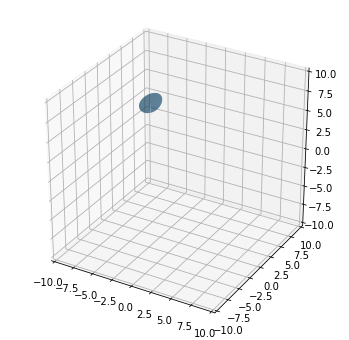

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Make data

u = np.linspace(0, 2 * np.pi, 100)

v = np.linspace(0, np.pi, 100)

x = 10 * np.outer(np.cos(u), np.sin(v))

y = 10 * np.outer(np.sin(u), np.sin(v))

z = 10 * np.outer(np.ones(np.size(u)), np.cos(v))

lam = lonout.reshape(nlat,nlon) * np.pi/180.0
the = latout.reshape(nlat,nlon) * np.pi/180.0
#lam = lonin.reshape(1,-1) * np.pi/180.0
#the = latin.reshape(-1,1) * np.pi/180.0
xc = 10 * np.cos(lam) * np.cos(the)
yc = 10 * np.sin(lam) * np.cos(the)
zc = 10 * np.sin(the)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111,projection='3d')
ax.set_xlim3d(-10.0,10.0)
ax.set_ylim3d(-10.0,10.0)
ax.set_zlim3d(-10.0,10.0)
#ax.plot_surface(x,y,z,color="lightgreen",rcount=100,ccount=100,antialiased=False)
ax.plot_surface(xc,yc,zc)

plt.show()

In [54]:
data = xr.open_dataset(datadir / innc).sel(time=date)
print(data["longitude"])
pd.date_range(date,periods=1)

<xarray.DataArray 'longitude' (longitude: 61)>
array([120. , 120.5, 121. , 121.5, 122. , 122.5, 123. , 123.5, 124. , 124.5,
       125. , 125.5, 126. , 126.5, 127. , 127.5, 128. , 128.5, 129. , 129.5,
       130. , 130.5, 131. , 131.5, 132. , 132.5, 133. , 133.5, 134. , 134.5,
       135. , 135.5, 136. , 136.5, 137. , 137.5, 138. , 138.5, 139. , 139.5,
       140. , 140.5, 141. , 141.5, 142. , 142.5, 143. , 143.5, 144. , 144.5,
       145. , 145.5, 146. , 146.5, 147. , 147.5, 148. , 148.5, 149. , 149.5,
       150. ])
Coordinates:
    time       datetime64[ns] 2019-10-09
  * longitude  (longitude) float64 120.0 120.5 121.0 121.5 ... 149.0 149.5 150.0
Attributes:
    standard_name:  longitude
    long_name:      longitude
    units:          degrees_east
    axis:           X


DatetimeIndex(['2019-10-09'], dtype='datetime64[ns]', freq='D')

In [20]:
import netCDF4

fname = innc
nc = netCDF4.Dataset(fname,'r')
dim = nc.dimensions.values()
var = nc.variables["time"]
#for dimobj in dim:
#    print(dimobj)
#for variable in var:
#    print(variable)
print(var)
nc.close()

<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    long_name: verification time generated by wgrib2 function verftime()
    units: seconds since 1970-01-01 00:00:00.0 0:00
    calendar: standard
    axis: T
unlimited dimensions: time
current shape = (29,)
filling on, default _FillValue of 9.969209968386869e+36 used


In [4]:
from pathlib import Path
from datetime import datetime, timedelta
import xarray as xr
import pandas as pd
#import librotate

#Usage echo yyyymmddhh nlon nlat latmax | python rotate_uv.py
#param = sys.stdin.readline().strip("\n").split(" ")
param = ["2019100900","10","5","8"]
yyyymmddhh = param[0]
nlon       = int(param[1])
nlat       = int(param[2])
latmax     = float(param[3]) #degree
dlat       = latmax/nlat #degree

datadir = Path('./')
outdir  = Path('./')
innc    = yyyymmddhh + '_mean.nc'
outnc   = 'np_ve_' + innc
trackf  = Path('./track' + yyyymmddhh + '.txt')

var_sfc = ['UGRD_10maboveground','VGRD_10maboveground']
var_pl  = ['UGRD_000mb','VGRD_000mb']

lonin,latin = generate_points(nlon,nlat,dlat)

da_np = []
with trackf.open() as track:
    #for l in track:
    l = track.readline()
    l_split = l.split()
    print(l_split)
    year     = l_split[0]
    month    = l_split[1]
    day      = l_split[2]
    hour     = l_split[3]
    date_str = year + '/' + month + '/' + day + ' ' + hour + ':00'
    date     = datetime.strptime(date_str, '%Y/%m/%d %H:%M')
    print(date)
    lonc     = float(l_split[4])
    latc     = float(l_split[5])
    print(lonc,latc)
        
    lonout,latout = rotate_lonlat(lonc,latc,lonin,latin)
    print(lonout,latout)
        
    data = xr.open_dataset(datadir / innc).sel(time=date)
    print(data)
        
    lon = data["longitude"].values
    lat = data["latitude"].values
    newlon = xr.DataArray(lonout,dims='np_lonlat')
    newlat = xr.DataArray(latout,dims='np_lonlat')
        
    #sfc
    u = data[var_sfc[0]].values
    v = data[var_sfc[1]].values 
    print(u.shape)
    attrs_u = data[var_sfc[0]].attrs
    attrs_v = data[var_sfc[1]].attrs
    #missing values need to be searched
    dfu = data[var_sfc[0]].to_pandas()
    dfv = data[var_sfc[1]].to_pandas()
    if(dfu.isnull().values.sum() != 0 or dfv.isnull().values.sum() != 0):
        print("missing value exists in input")
        sys.exit()
    lon2d = lon.reshape(1,-1)
    lat2d = lat.reshape(-1,1)
    xd,yd,zd = uv2xyzd(u,v,lon2d,lat2d)
    print(xd.reshape(1,len(lat),len(lon))==xd)
        
    da_xd = xr.DataArray(xd.reshape(1,len(lat),len(lon)),
                         [('time',pd.date_range(date,periods=1)),('latitude',lat),('longitude',lon)],
                         name='xd')
    da_yd = xr.DataArray(yd.reshape(1,len(lat),len(lon)),
                         [('time',pd.date_range(date,periods=1)),('latitude',lat),('longitude',lon)],
                         name='yd')
    da_zd = xr.DataArray(zd.reshape(1,len(lat),len(lon)),
                         [('time',pd.date_range(date,periods=1)),('latitude',lat),('longitude',lon)],
                         name='zd')
        
    xd_interp = da_xd.interp(longitude=newlon, latitude=newlat)
    yd_interp = da_yd.interp(longitude=newlon, latitude=newlat)
    zd_interp = da_zd.interp(longitude=newlon, latitude=newlat)
    print(xd_interp)
    #missing value
    dfx = xd_interp.to_pandas()
    dfy = yd_interp.to_pandas()
    dfz = zd_interp.to_pandas()
    if(dfx.isnull().values.sum() != 0 or dfy.isnull().values.sum() != 0 or
       dfz.isnull().values.sum() != 0):
        print("missing value exists in interpolation")
        sys.exit()
         
    xdtc = xd_interp.values.reshape(nlat,nlon)
    ydtc = yd_interp.values.reshape(nlat,nlon)
    zdtc = zd_interp.values.reshape(nlat,nlon)
    xdnp,ydnp,zdnp = tc2np(lonc,latc,xdtc,ydtc,zdtc)
    #missing value
    if(np.isnan(xdnp).sum() != 0 or np.isnan(ydnp).sum() != 0 or \
       np.isnan(zdnp).sum() != 0):
        print("missing value exists in tc2np")
        sys.exit()
            
    lonnp = lonin.reshape(1,-1)
    unp,vnp = xyzd2uv(xdnp,ydnp,zdnp,lonnp)
    #missing value
    if(np.isnan(unp).sum() != 0 or np.isnan(vnp).sum() != 0):
        print("missing value exists in xyzd2uv")
        sys.exit()
        
    udata = xr.DataArray(unp.reshape(1,nlat,nlon),\
                             [('time',pd.date_range(date,periods=1)),\
                              ('latitude',latin),('longitude',lonin)],\
                             attrs=attrs_u,name=var_sfc[0])
    vdata = xr.DataArray(vnp.reshape(1,nlat,nlon),\
                             [('time',pd.date_range(date,periods=1)),\
                              ('latitude',latin),('longitude',lonin)],\
                             attrs=attrs_v,name=var_sfc[1])
    print(udata)
    print(vdata)
    daout.append(udata)
    daout.append(vdata)

['2019', '10', '9', '0', '140.0347168059274', '19.98207077834067', '95650.44815609399']
2019-10-09 00:00:00
140.0347168059274 19.98207077834067
[140.03471681 140.03471681 140.03471681 140.03471681 140.03471681
 140.03471681 140.03471681 140.03471681 140.03471681 140.03471681
 140.03471681 141.02741874 141.64880817 141.6589666  141.0438645
 140.03471681 139.02556912 138.41046701 138.42062544 139.04201487
 140.03471681 142.00500355 143.25279194 143.29339291 142.07084229
 140.03471681 137.99859132 136.7760407  136.81664167 138.06443006
 140.03471681 142.9687485  144.84675036 144.93797972 143.11709465
 140.03471681 136.95233896 135.13145389 135.22268325 137.10068511
 140.03471681 143.91988371 146.43079564 146.59267577 144.18413057
 140.03471681 135.88530305 133.47675784 133.63863797 136.14954991] [19.98207078 19.98207078 19.98207078 19.98207078 19.98207078 19.98207078
 19.98207078 19.98207078 19.98207078 19.98207078 18.38207078 18.68491721
 19.48037737 20.46906941 21.2736092  21.58207078 2

In [12]:
latin = np.arange(5)
lonin = np.arange(5)
latout = latin
lonout = np.array([0.5,1.25,2,2.75,3.5])
x = np.arange(25).reshape(5,5)
da = xr.DataArray(x,[('lat',latin),('lon',lonin)])
print(da)
newlon = xr.DataArray(lonout,dims='lonlat')
newlat = xr.DataArray(latout,dims='lonlat')
da_interp = da.interp(lon=newlon,lat=newlat)
print(da_interp)

<xarray.DataArray (lat: 5, lon: 5)>
array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])
Coordinates:
  * lat      (lat) int64 0 1 2 3 4
  * lon      (lon) int64 0 1 2 3 4
<xarray.DataArray (lonlat: 5)>
array([ 0.5 ,  6.25, 12.  , 17.75, 23.5 ])
Coordinates:
    lon      (lonlat) float64 0.5 1.25 2.0 2.75 3.5
    lat      (lonlat) int64 0 1 2 3 4
Dimensions without coordinates: lonlat
